In [2]:
import gymnasium as gym  # Updated from gym to gymnasium [1]
from gymnasium import spaces
from gymnasium.core import ActionWrapper, Wrapper
import torch
import torch.nn as nn
import numpy as np
from collections import deque
import random
from itertools import count
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter  # Updated tensorboard import [1]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
class QNetwork(nn.Module):
    def __init__(self, actions):
        super().__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(8, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(128, 64),  # Combines value/advantage intermediate layers
            nn.ReLU(),
            nn.Linear(64, 24)     # Direct action-value outputs
        )

    def forward(self, state):
        x = self.fc1(state)
        return self.fc2(x)

    def select_action(self, state):
        with torch.no_grad():
            q_values = self(state)  # Direct call instead of forward() [1]
            return torch.argmax(q_values).item()


class Memory(deque):  # Simplified memory implementation [1]
    def __init__(self, capacity):
        super().__init__(maxlen=capacity)

    def sample(self, batch_size):
        return random.sample(self, batch_size)


In [ ]:
# Define custom no-op actions
class MultiNoOpWrapper(ActionWrapper):
    def __init__(self, env: gym.Env, n_noop: int, noop_action: int = 0):
        super().__init__(env)
        assert isinstance(env.action_space, spaces.Discrete), \
               "MultiNoOpWrapper only works for Discrete action spaces"

        self.orig_n     = env.action_space.n
        self.n_noop     = n_noop
        self.noop_action = noop_action

        # extend the action space
        self.action_space = spaces.Discrete(self.orig_n + self.n_noop)

    def action(self, action: int) -> int:
        # any new index ≥ orig_n becomes the no-op
        if action >= self.orig_n:
            return self.noop_action
        return action

In [5]:
# Updated environment creation [1]
env = gym.make("LunarLander-v3")
env = MultiNoOpWrapper(env, n_noop=20, noop_action=0)
n_state = env.observation_space.shape[0]

online_net = QNetwork(24).to(device)
target_net = QNetwork(24).to(device)
target_net.load_state_dict(online_net.state_dict())

optimizer = torch.optim.AdamW(online_net.parameters(), lr=1e-4)  # Modern optimizer [1]


In [ ]:
BATCH_SIZE = 64
NUM_EPISODES = 410
UPDATE_INTERVAL = 4
GAMMA = 0.99
EPS_START = 0.5
EPS_END = 0.01
EPS_DECAY = (EPS_END/EPS_START)**(1.0/NUM_EPISODES*0.1)
learning_steps = 0


memory = Memory(50000)
writer = SummaryWriter('logs/dqn/lunarlander_degraded')

In [ ]:
epsilon = EPS_START
episode_reward = 0

for epoch in range(NUM_EPISODES):
    state, _ = env.reset()  # Updated reset unpacking [1]
    episode_reward = 0

    for t in count():
        # Epsilon-greedy action selection
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            action = online_net.select_action(state_tensor)

        # Updated step returns unpacking [1]
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        episode_reward += reward
        memory.append((state, next_state, action, reward, done))

        if len(memory) >= BATCH_SIZE:
            # Experience replay
            transitions = memory.sample(BATCH_SIZE)
            batch = list(zip(*transitions))
            learning_steps += 1

            # Update target network
            if learning_steps % UPDATE_INTERVAL == 0:
                target_net.load_state_dict(online_net.state_dict())

            states = torch.tensor(batch[0], dtype=torch.float32, device=device)
            next_states = torch.tensor(batch[1], dtype=torch.float32, device=device)
            actions = torch.tensor(batch[2], dtype=torch.long, device=device).unsqueeze(1)
            rewards = torch.tensor(batch[3], dtype=torch.float32, device=device).unsqueeze(1)
            dones = torch.tensor(batch[4], dtype=torch.float32, device=device).unsqueeze(1)

            # Double DQN update
            with torch.no_grad():
                next_actions = online_net(next_states).argmax(1, keepdim=True)
                target_q = target_net(next_states).gather(1, next_actions)
                target = rewards + (1 - dones) * GAMMA * target_q

            current_q = online_net(states).gather(1, actions)
            loss = F.mse_loss(current_q, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epsilon = max(epsilon * EPS_DECAY, EPS_END)


        if done:
            break
        state = next_state

    writer.add_scalar('episode_reward', episode_reward, epoch)

    if epoch % 10 == 0:
        torch.save(online_net.state_dict(), 'dqn-policy-lunar.pt')  # Updated file extension [1]
        print(f'Epoch {epoch}: Reward {episode_reward:.2f}, epsilon {epsilon:.4f}')


<ipython-input-7-eded81f30cb1>:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  states = torch.tensor(batch[0], dtype=torch.float32, device=device)


Epoch 0: Reward -137.53, epsilon 0.4973
Epoch 10: Reward -155.31, epsilon 0.3687
Epoch 20: Reward -125.11, epsilon 0.2690
Epoch 30: Reward -160.09, epsilon 0.2061
Epoch 40: Reward -195.41, epsilon 0.1457
Epoch 50: Reward -113.30, epsilon 0.1120
Epoch 60: Reward -176.44, epsilon 0.0828
Epoch 70: Reward -141.58, epsilon 0.0646
Epoch 80: Reward -205.65, epsilon 0.0420
Epoch 90: Reward -180.59, epsilon 0.0264
Epoch 100: Reward -189.74, epsilon 0.0135
Epoch 110: Reward -437.99, epsilon 0.0100
Epoch 120: Reward -105.25, epsilon 0.0100
Epoch 130: Reward -190.42, epsilon 0.0100
Epoch 140: Reward -73.26, epsilon 0.0100
Epoch 150: Reward -420.90, epsilon 0.0100
Epoch 160: Reward -123.62, epsilon 0.0100
Epoch 170: Reward -57.65, epsilon 0.0100
Epoch 180: Reward -101.56, epsilon 0.0100
Epoch 190: Reward -146.65, epsilon 0.0100
Epoch 200: Reward -30.00, epsilon 0.0100
Epoch 210: Reward -61.16, epsilon 0.0100
Epoch 220: Reward -69.34, epsilon 0.0100
Epoch 230: Reward -61.28, epsilon 0.0100
Epoch 240

In [8]:
writer.close()

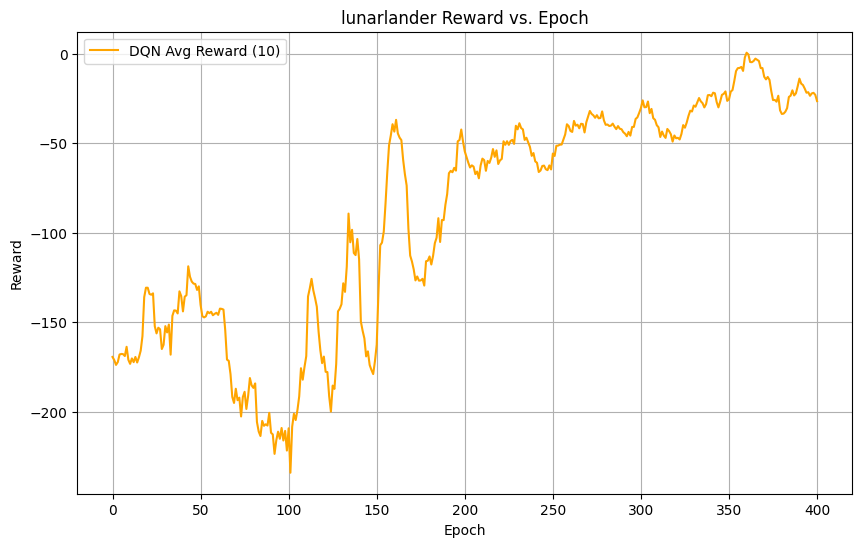

In [10]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

event_acc = EventAccumulator('logs/dqn/lunarlander_degraded')
event_acc.Reload()

# Extract the reward vs. epoch data
reward_events = event_acc.Scalars('episode_reward')
epochs = [event.step for event in reward_events]
rewards_dqn = [event.value for event in reward_events]
rewards_dqn = np.convolve(rewards_dqn, np.ones(10)/10, mode='valid')



# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(range(len(rewards_dqn)), rewards_dqn, label='DQN Avg Reward (10)', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Reward')
plt.title('lunarlander Reward vs. Epoch')
plt.legend()
plt.grid()
plt.show()

In [12]:
np.savetxt('dqn_rewards_20_noop.txt', rewards_dqn, fmt="%d")